In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipynb.fs.full.Functions import calc_Truths, Sensitivity, profile
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve, auc,recall_score,precision_score,mean_squared_error
import time
import xgboost as xgb

In [65]:
#Read in the training data
df1 = pd.read_csv('./../CSVfiles/ggH.csv')
df2 = pd.read_csv('./../CSVfiles/data_yyjj_p1.csv')

print('There is %.2f percent signal data' % ((len(df1)/len(df2))*100))

#Full MC dataset 
df = pd.concat([df1,df2])
del df1,df2

#Transform data to remove mass bias 
df['g1_pt'] = df['g1_pt']/(df['p_mass']*1000)
df['g2_pt'] = df['g2_pt']/(df['p_mass']*1000)
df['g1_E'] = df['g1_E']/(df['p_mass']*1000)
df['g2_E'] = df['g2_E']/(df['p_mass']*1000)


#Drop columns which have NaN values filled in, as this 
#will allow the classifier to cheat
df.drop(['p_E', 'p_pt', 'p_eta', 'p_phi', 'g1_trigm', 'g2_trigm', 'trigP', 'g1_ptcone', 'g2_ptcone',
        'g1_etacone', 'g2_etacone'], axis = 1, inplace = True)

for i in range(1,15):
    df.drop(['j{}_MV2C10'.format(i)], axis = 1, inplace = True)

#Split MC data into training and validation sets
x_train, x_val, y_train, y_val, m_train, m_val = train_test_split(df.iloc[:, 2:], df.iloc[:, 0], df.iloc[:, 1],
                                                                     test_size=0.2, shuffle = True)

#Convert to dtype for XGBoost
dtrain = xgb.DMatrix(data = x_train, label = y_train)
dval = xgb.DMatrix(data = x_val, label = y_val)

#To perform operations on disk instead of in RAM (for large files)
# dtrain = xgb.DMatrix(data = './../CSVfiles/training_data.csv?format=csv&label_column=0#traincache')
# dval = xgb.DMatrix(data = './../CSVfiles/validation_data.csv?format=csv&label_column=0#valcache')

#Clear unnecessary memory use
del df

There is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0.26 percent signal dataThere is 0

In [66]:
#Set error function, nthread is for No. CPU threads
#Watchlist prints error statistics, num_round is iterations
param = {'objective':'binary:logistic', 'nthread': '-1', 'eta':'0.07', 'max_depth': '4'}
watchlist = [(dtrain, 'train'),(dval, 'eval')]
num_round = 100

#Fit the model to the training data
training_start = time.perf_counter()
model = xgb.train(param, dtrain, num_round, watchlist)
training_end = time.perf_counter()

[17:51:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.65670	eval-logloss:0.65689
[1]	train-logloss:0.62479	eval-logloss:0.62522
[2]	train-logloss:0.59674	eval-logloss:0.59708
[3]	train-logloss:0.57164	eval-logloss:0.57214
[4]	train-logloss:0.54915	eval-logloss:0.54977
[5]	train-logloss:0.52904	eval-logloss:0.52990
[6]	train-logloss:0.51011	eval-logloss:0.51101
[7]	train-logloss:0.49389	eval-logloss:0.49489
[8]	train-logloss:0.47819	eval-logloss:0.47940
[9]	train-logloss:0.46466	eval-logloss:0.46586
[10]	train-logloss:0.45131	eval-logloss:0.45269
[11]	train-logloss:0.43959	eval-logloss:0.44097
[12]	train-logloss:0.42909	eval-logloss:0.43051
[13]	train-logloss:0.41916	eval-logloss:0.42077
[14]	train-logloss:0.40961	e

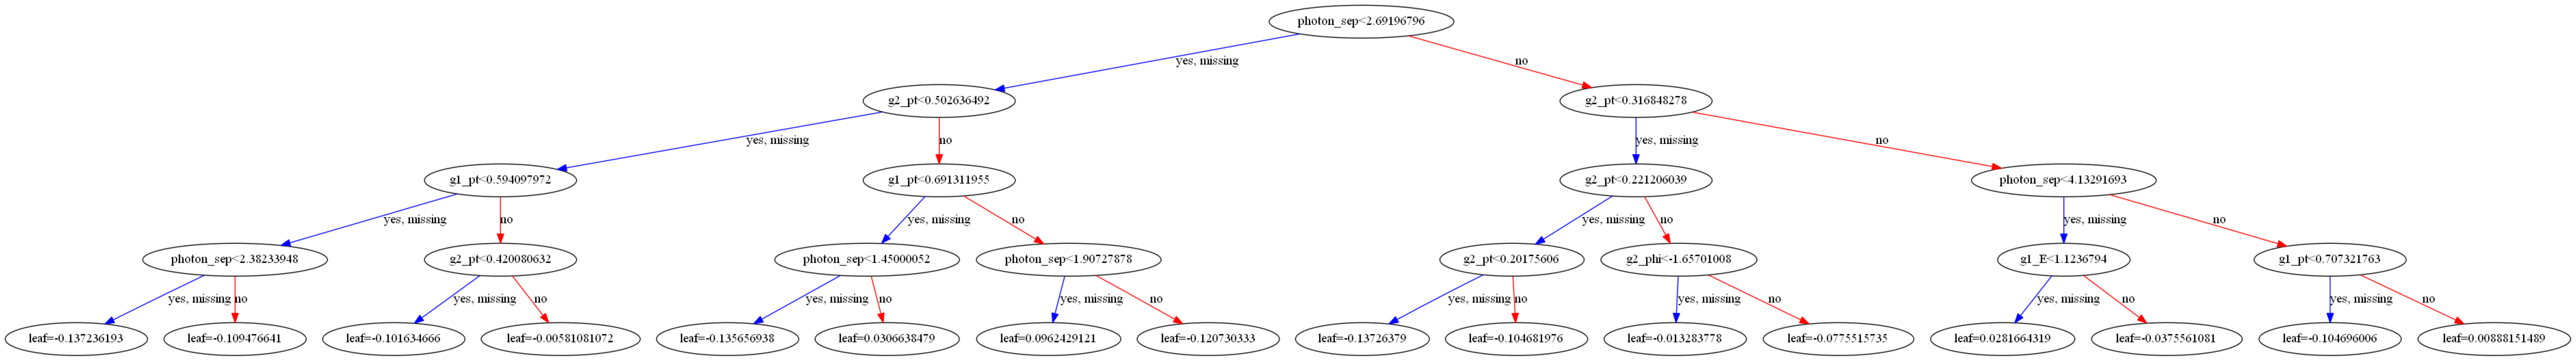

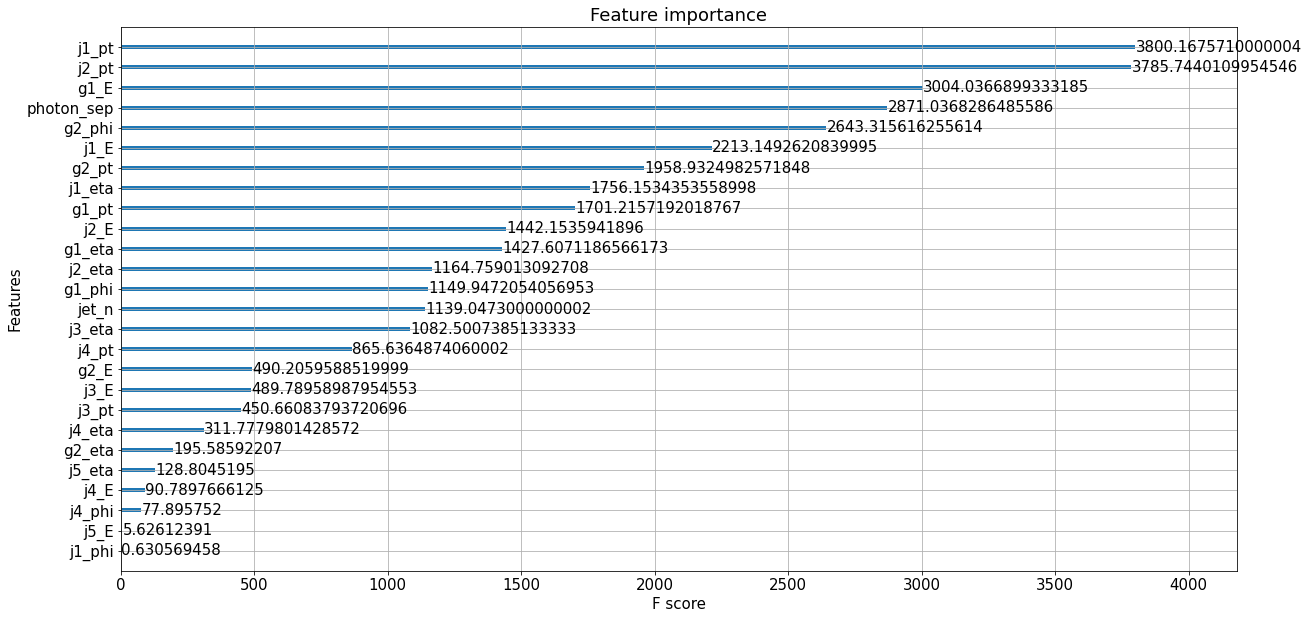

In [67]:
#Visualise the tree
plt.rcParams['figure.figsize'] = [200, 100]
xgb.plot_tree(model)
plt.savefig('./../Graphs/tree.png')

#Demonstrate the feature importances
plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = [20,10]
xgb.plot_importance(model, importance_type='gain')
plt.show()

Training time was: 29.446769700000004
Prediction time was: 0.06307860000015353
Number of correct predictions:  162057  and number of incorrect:  17177
Accuracy: 90.42%


<Figure size 1200x600 with 0 Axes>

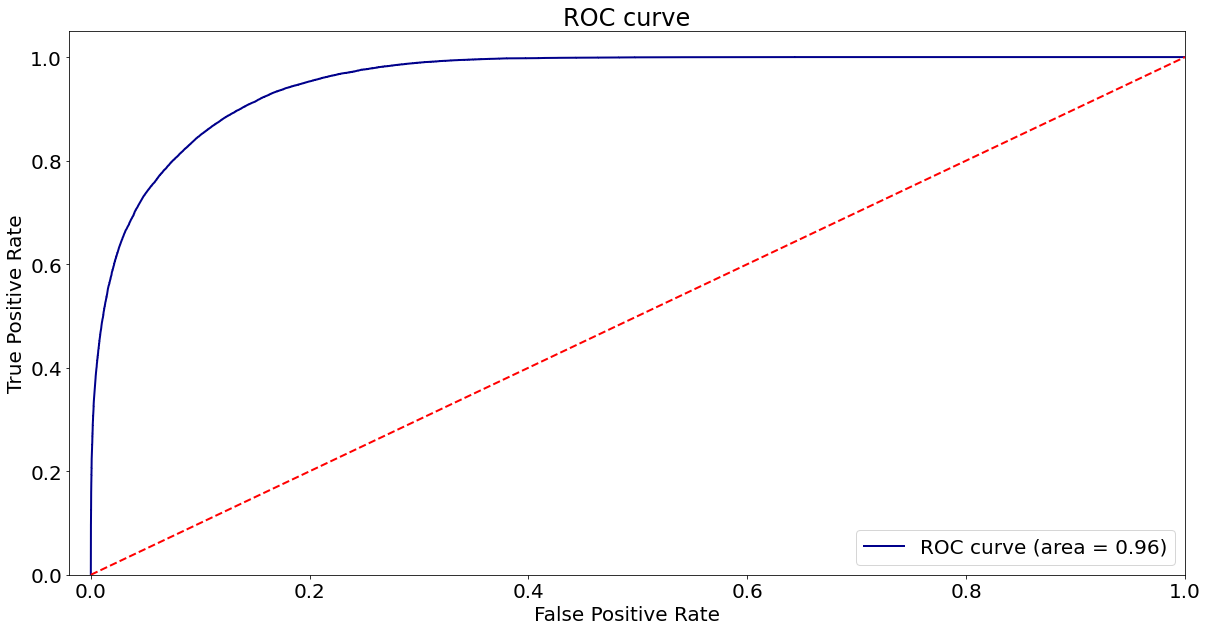

In [68]:
#To observe model behaviour, compare original labels to validation set
prediction_start = time.perf_counter()
predictions = model.predict(dval)
prediction_end = time.perf_counter()
y_preds = np.rint(predictions)

#Evaluate how well the model performs

#Time efficiency
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print('Training time was: {}'.format(xgb_train_time))
print('Prediction time was: {}'.format(xgb_prediction_time))

tru = 0
fal = 0
labels = y_val.values
for i in range(len(labels)):
    if labels[i] == y_preds[i]:
        tru += 1
    elif labels[i] != y_preds[i]:
        fal += 1
    else:
        print('Error')

print('Number of correct predictions: ', tru, ' and number of incorrect: ', fal)

#Show accuracy
accuracy = accuracy_score(labels, y_preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#Plot ROC curve
plt.figure(figsize=(12,6), dpi= 100)
fpr, tpr, _ = roc_curve(labels, predictions)
roc_auc = auc(fpr, tpr)
plt.rcParams.update({'font.size': 20})
plt.figure()
plt.plot(fpr, tpr, color='darkblue',
        lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

32787 7009
Sensitivity on cut 0.10:  269.52  with effsig: 0.99  with rj: 0.32
32397 5806
Sensitivity on cut 0.14:  281.35  with effsig: 0.98  with rj: 0.26
31825 4793
Sensitivity on cut 0.18:  292.00  with effsig: 0.96  with rj: 0.21
31045 3896
Sensitivity on cut 0.23:  302.01  with effsig: 0.94  with rj: 0.17
29988 3164
Sensitivity on cut 0.27:  309.50  with effsig: 0.90  with rj: 0.14
28790 2524
Sensitivity on cut 0.31:  316.43  with effsig: 0.87  with rj: 0.11
27423 1960
Sensitivity on cut 0.35:  322.90  with effsig: 0.82  with rj: 0.09
25987 1479
Sensitivity on cut 0.39:  329.42  with effsig: 0.78  with rj: 0.07
24306 1060
Sensitivity on cut 0.44:  335.36  with effsig: 0.73  with rj: 0.05
22660 785
Sensitivity on cut 0.48:  337.57  with effsig: 0.68  with rj: 0.04
20932 558
Sensitivity on cut 0.52:  339.20  with effsig: 0.63  with rj: 0.02
19032 401
Sensitivity on cut 0.56:  335.81  with effsig: 0.57  with rj: 0.02
17187 263
Sensitivity on cut 0.61:  334.71  with effsig: 0.51  with

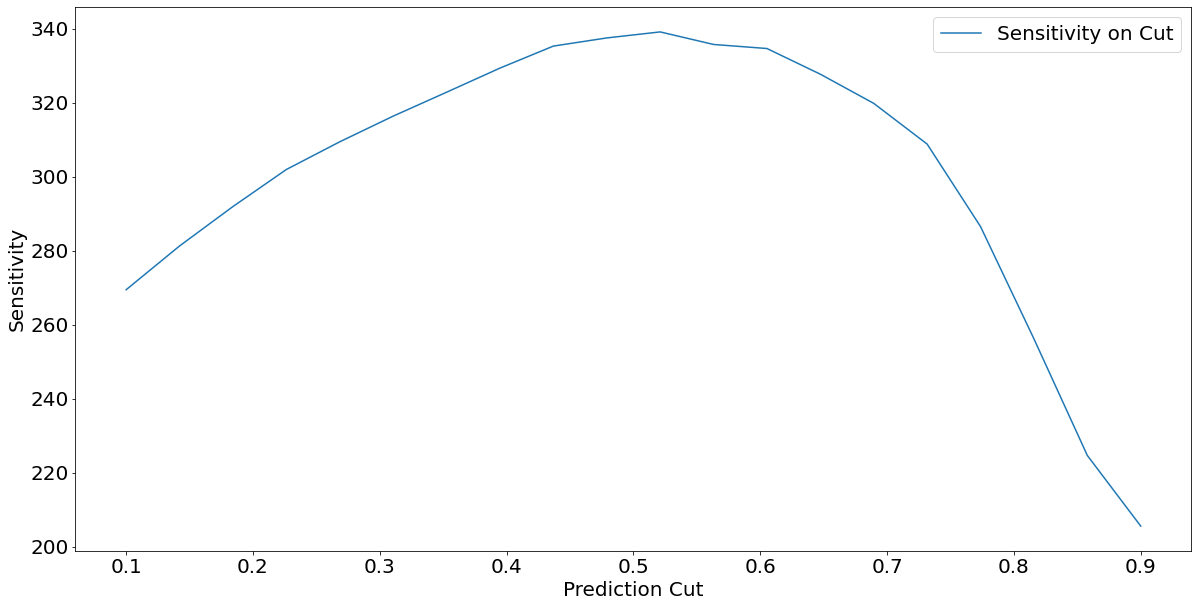

In [69]:
#Sensitivity over different cuts
ss = []
t = np.linspace(0.1,0.9,20,endpoint=True)
for i in t:
    true_pos, false_pos, true_neg, false_neg = calc_Truths(predictions, y_val.values, m_val.values, threshold = i)
    eff_sig = len(true_pos)/(len(true_pos)+len(false_neg))
    eff_bkg = len(false_pos)/(len(false_pos)+len(true_neg))
    sensitivity = Sensitivity(true_pos, false_pos)
    ss.append(sensitivity)
    print('Sensitivity on cut %.2f: '%i, '%.2f' % sensitivity,' with effsig: %.2f' % eff_sig,' with rj: %.2f'% eff_bkg)
best_cut = t[ss.index(max(ss))]
print('Best at: %.2f'% best_cut)

#Plot sensitivities
plt.plot(t, ss, label = 'Sensitivity on Cut')
plt.xlabel('Prediction Cut')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

20932 558
Best effsig: 0.63
Best rj: 0.02
Best Sensitivity: 339.20


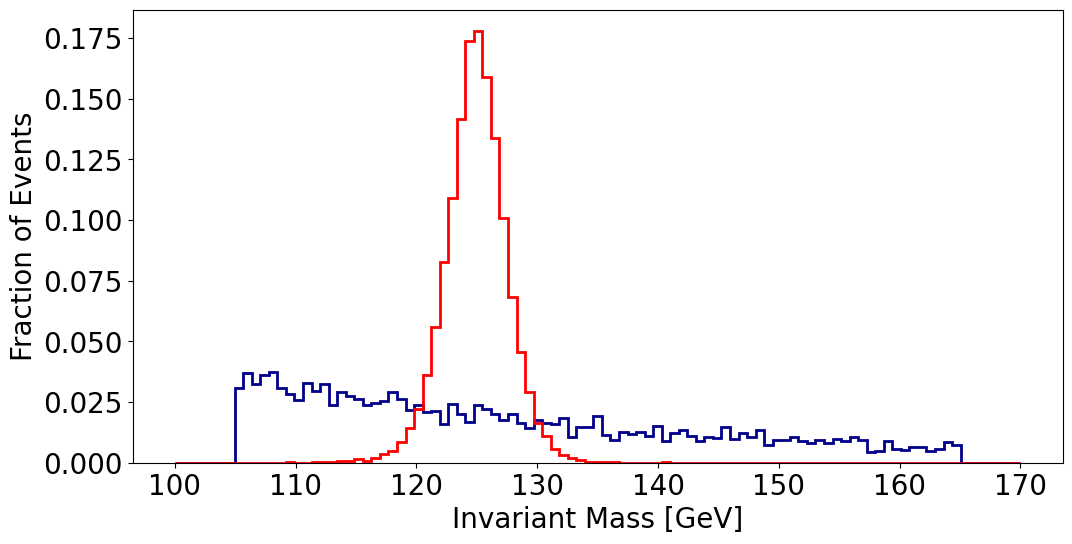

C:\Users\jamie\CernOpenData\Code\Functions.ipynb:333: RuntimeWarning: Mean of empty slice.
  "\n",
C:\Users\jamie\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


<Figure size 1200x600 with 0 Axes>

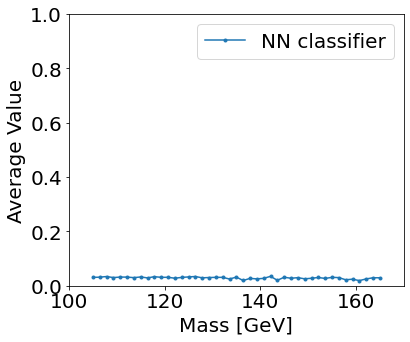

In [70]:
#Get info for the best cut
true_pos, false_pos, true_neg, false_neg = calc_Truths(predictions, y_val.values, m_val.values, threshold = best_cut)
eff_sig = len(true_pos)/(len(true_pos)+len(false_neg))
eff_bkg = len(false_pos)/(len(false_pos)+len(true_neg))
sensitivity = Sensitivity(true_pos, false_pos)
print('Best effsig: %.2f'%  eff_sig)
print('Best rj: %.2f'%  eff_bkg)
print('Best Sensitivity: %.2f'%  sensitivity)

#Plot resulting mass spectrum passing cut
plt.figure(figsize=(12,6), dpi= 100)
xlims=[100, 170]
bins = np.linspace(xlims[0],xlims[1],100,endpoint=True)
plt.hist(false_pos, color = 'darkblue', histtype='step', density = True, bins=bins,linewidth=2)
plt.hist(true_pos, color = 'red', histtype='step', density = True, bins=bins,linewidth=2)
plt.xlabel('Invariant Mass [GeV]')
plt.ylabel('Fraction of Events')
plt.show()

#Plot mass sculpting graph
profile(m_val.values[y_val==0], y_preds[y_val==0], labels='NN classifier')

#Get rid of unused data
del dtrain, dval, x_train, x_val, y_train, y_val, m_train, m_val

In [71]:
#Read in each data for predicting the labels
df1 = pd.read_csv('./../CSVfiles/dataA.csv')
df2 = pd.read_csv('./../CSVfiles/dataB.csv')
df3 = pd.read_csv('./../CSVfiles/dataC.csv')
df4 = pd.read_csv('./../CSVfiles/dataD.csv')

df5 = pd.concat([df1,df2])
del df1, df2
df6 = pd.concat([df3,df4])
del df3,df4
df = pd.concat([df5,df6])
del df5,df6

df['g1_pt'] = df['g1_pt']/(df['p_mass']*1000)
df['g2_pt'] = df['g2_pt']/(df['p_mass']*1000)
df['g1_E'] = df['g1_E']/(df['p_mass']*1000)
df['g2_E'] = df['g2_E']/(df['p_mass']*1000)

df.drop(['p_E', 'p_pt', 'p_eta', 'p_phi', 'g1_trigm', 'g2_trigm', 'trigP', 'g1_ptcone', 'g2_ptcone',
        'g1_etacone', 'g2_etacone'], axis = 1, inplace = True)

for i in range(1,15):
    df.drop(['j{}_MV2C10'.format(i)], axis = 1, inplace = True)

x_data = df.iloc[:,1:]
m_data = df['p_mass'].values

#We can now predict labels of the data
dtest = xgb.DMatrix(data = x_data)
predictions = model.predict(dtest)
y_preds = np.rint(predictions)

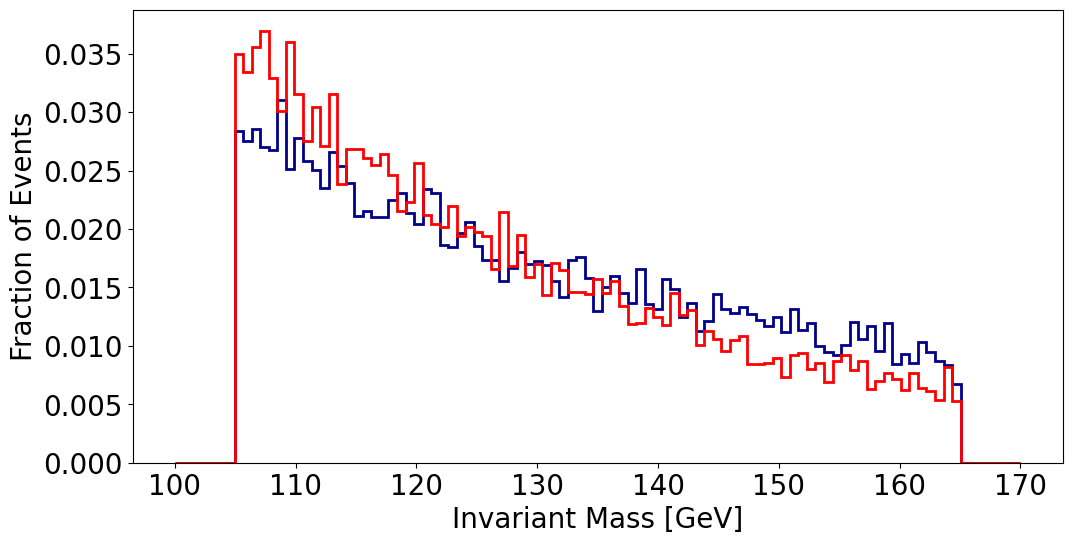

14786
13039


In [72]:
#Do a plot of the mass spectrum
plt.figure(figsize=(12,6), dpi= 100)
sigs = m_data[predictions >= best_cut]
bkgs = m_data[predictions < best_cut]
xlims=[100, 170]
bins = np.linspace(xlims[0],xlims[1],100,endpoint=True)
plt.hist(bkgs, color = 'darkblue', histtype='step', density = True, bins=bins,linewidth=2)
plt.hist(sigs, color = 'red', histtype='step', density = True, bins=bins,linewidth=2)
#plt.hist(m_data, color = 'green', histtype='step', density = True, bins=bins,linewidth=2)
plt.xlabel('Invariant Mass [GeV]')
plt.ylabel('Fraction of Events')
plt.show()
print(len(sigs))
print(len(bkgs))